<a href="https://colab.research.google.com/github/mbendjilali/Archive/blob/main/Classification_signLanguage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# adresse mail : michelle.aubrun@thalesaleniaspace.com à rendre le 01/04/2022

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import copy


# Fix seed for duplication
np.random.seed(123)
torch.manual_seed(123)

##Dataset object to load *data*

In [2]:
class ImageDataset(Dataset):

    def __init__(self, im, im_ind, train=True):
        """
        :param im:  List of image 
        :param im_ind: List of class Indice
        :param train: Bool, True if training mod
        """
        self.im = im
        self.im_ind = im_ind
        self.train = train

    def __len__(self):
        return len(self.im)

    def __getitem__(self, index):
        # Get image & convert it in torch tensor
        image = self.im[index]
        tensor = transforms.ToTensor()(image)

        # Get class of the image (Groundtruth)
        class_image = self.im_ind[index]

        # Transform image with torchvision functions (if train mod)
        if self.train :
          to_tensor = transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.3)
          tensor = to_tensor(tensor)
        # Normalize image
        # normalize = nn.functional.normalize()

        return tensor, class_image

##Neural Network *model*

In [3]:
class MyNetwork(nn.Module):

    def __init__(self, num_out):
        self.num_out = num_out # output size of the last layer
        super(MyNetwork, self).__init__()

        # Create an encoder
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
        )

        # Add fully connected layers to learn the specific task
        self.fc = nn.Sequential(
            nn.Linear(18496, 250),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(250, self.num_out),
            nn.Softmax(dim=1),
        )
        self.model.to(device)
        self.fc.to(device)

    # Forward function of the classification model
    def forward(self, input):
        output = self.model(input)
        output = torch.flatten(output, 1)
        output = self.fc(output)

        return output

##Load data

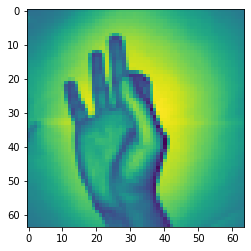

In [5]:
# Load input data and labels
data_input = np.load("X.npy")
data_label = np.load("Y.npy")

# Visualize data

plt.imshow(data_input[0])

# Split the dataset in train, val and test data (with sklearn.model_selection.train_test_split function)

X_train, X_test, Y_train, Y_test = train_test_split(data_input, data_label, test_size=0.33, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.33, random_state=42)

# Generate batches of train and val data (with imageDataset class above and torch.utils.data.DataLoader class)

train_dataset  = ImageDataset(X_train, Y_train, train = True)
val_dataset = ImageDataset(X_val, Y_val, train = False)


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    

##Training the model

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# --------------- Model architecture -----------------

num_epochs = 10
best_acc = 0.0
n = 10 # number of classes

# define model architecture
network = MyNetwork(n)


# define loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.Adam([dict(params=network.parameters(), lr = 0.00008),])


# Training
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        epoch_loss = []
        epoch_acc = 0

        if phase=='train':
            # Model in training mod

            loader = train_dataloader
        else:
            # Model in evaluation mod
            loader = val_dataloader

        for i, data in enumerate(loader):
            # Load image and class inside a batch 
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Set the gradient to zero
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'): # compute or not the gradient
                # Apply the model & compute the loss
                outputs = network(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)
                epoch_acc += torch.sum(preds == torch.argmax(labels,1))
                epoch_loss.append(loss.item())

                if phase == 'train':
                    # compute the gradient & update parameters
                    loss.backward()
                    optimizer.step()
        # Display loss
        mean_loss_epoch = np.mean(epoch_loss)
        std_loss_epoch = np.std(epoch_loss)
        if phase == 'train':
            print(f'Epoch: {epoch + 1}, Loss_train: {mean_loss_epoch:.4f} (± {std_loss_epoch:.4f})')
        else:
            print(f'Epoch: {epoch + 1}, Loss_val: {mean_loss_epoch:.4f} (± {std_loss_epoch:.4f})')

            if epoch_acc> best_acc :
                # Keep curent model with copy function
                best_current_model = copy.deepcopy(network.state_dict())

# Save best classification model
torch.save(best_current_model, 'bestClassificationModel.pt')

Epoch: 1, Loss_train: 2.2458 (± 0.0467)
Epoch: 1, Loss_val: 2.1380 (± 0.0334)
Epoch: 2, Loss_train: 2.0686 (± 0.0679)
Epoch: 2, Loss_val: 1.9681 (± 0.0265)
Epoch: 3, Loss_train: 1.9241 (± 0.0507)
Epoch: 3, Loss_val: 1.8403 (± 0.0508)
Epoch: 4, Loss_train: 1.8183 (± 0.0377)
Epoch: 4, Loss_val: 1.7653 (± 0.0382)
Epoch: 5, Loss_train: 1.7455 (± 0.0369)
Epoch: 5, Loss_val: 1.7442 (± 0.0406)
Epoch: 6, Loss_train: 1.6958 (± 0.0293)
Epoch: 6, Loss_val: 1.6924 (± 0.0326)
Epoch: 7, Loss_train: 1.6634 (± 0.0284)
Epoch: 7, Loss_val: 1.6824 (± 0.0351)
Epoch: 8, Loss_train: 1.6322 (± 0.0292)
Epoch: 8, Loss_val: 1.6702 (± 0.0207)
Epoch: 9, Loss_train: 1.6097 (± 0.0283)
Epoch: 9, Loss_val: 1.6548 (± 0.0361)
Epoch: 10, Loss_train: 1.5979 (± 0.0398)
Epoch: 10, Loss_val: 1.6532 (± 0.0243)


##Evaluate the model

In [14]:
# Load classification model with its weights
bestNetwork = MyNetwork(10)

bestNetwork.load_state_dict(torch.load('bestClassificationModel.pt'))

# Generate batches of test data 

test_dataset = ImageDataset(X_test, Y_test, train = False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

preds_all = []
labels_all = []
correct = 0
total = 0
# Testing
with torch.no_grad(): # no gradient
    for i, data in enumerate(test_dataloader):
        # Load image and class inside a batch 
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels_all.extend(labels)
        total += labels.size(0)

        # Apply the model
        outputs = bestNetwork(inputs)
        preds = torch.argmax(outputs, 1)
        preds_all.append(preds)
        correct += (preds == torch.argmax(labels, 1)).sum().item()



# Display results
print(total)
print(correct)
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

456
382
Accuracy of the network on the 10000 test images: 83 %
